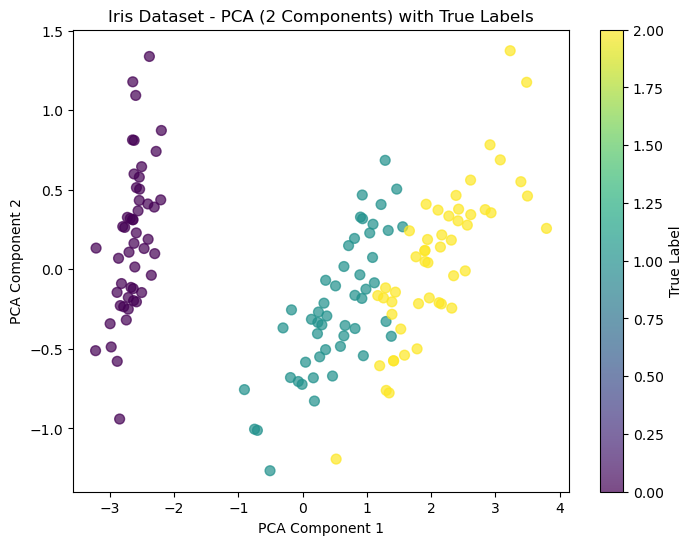

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X = iris.data 
y = iris.target 

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50, alpha=0.7)
plt.title('Iris Dataset - PCA (2 Components) with True Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='True Label')
plt.show()

In [14]:
class GaussianMixtureModel:
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
        self.k = k
        self.dim = dim
        if(init_mu is None):
            init_mu = np.random.rand(k, dim) * 20 - 10
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        if(init_pi is None):
            init_pi = np.ones(self.k) / self.k
        self.pi = init_pi
        if(colors is None):
            colors = np.random.rand(k, 3)
        self.colors = colors

    def e_step(self, data):
        self.z = np.zeros((data.shape[0], self.k))
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(data, mean=self.mu[i], cov=self.sigma[i])
        self.z /= self.z.sum(axis=1, keepdims=True)

    def m_step(self, data, reg=1e-6):
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / data.shape[0]
        self.mu = np.matmul(self.z.T, data)
        self.mu /= sum_z[:, None]
        
        for i in range(self.k):
            j = np.expand_dims(data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i])
            self.sigma[i] /= sum_z[i]
            
            self.sigma[i] += np.eye(self.dim) * reg

    def fit(self, data, max_iter=100):
        for _ in range(max_iter):
            self.e_step(data)
            self.m_step(data)

    def predict(self, data):
        z = np.zeros((data.shape[0], self.k))
        for i in range(self.k):
            z[:, i] = self.pi[i] * multivariate_normal.pdf(data, mean=self.mu[i], cov=self.sigma[i])
        z /= z.sum(axis=1, keepdims=True)
        return np.argmax(z, axis=1)

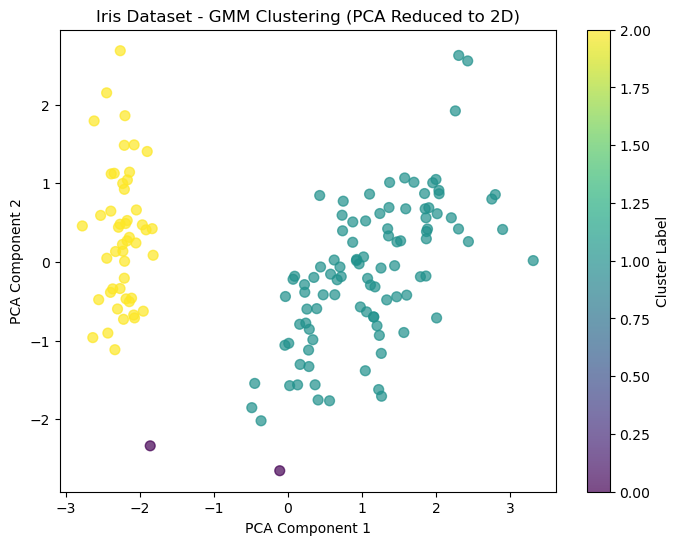

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

gmm = GaussianMixtureModel(k=3, dim=4)
gmm.fit(X_scaled)

y_pred = gmm.predict(X_scaled)

X_pca_gmm = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca_gmm[:, 0], X_pca_gmm[:, 1], c=y_pred, cmap='viridis', s=50, alpha=0.7)
plt.title('Iris Dataset - GMM Clustering (PCA Reduced to 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()